# About this Notebook

**Bayesian Temporal Tensor Factorization** (or **BTTF** for short) is a type of Bayesian tensor decomposition that achieves state-of-the-art results on challenging the missing data imputation problem. In the following, we will discuss:

- What the BTTF is?

- How to implement BTTF mainly using Python `Numpy` with high efficiency?

- How to make imputations with real-world spatiotemporal datasets?

If you want to understand what is BTMF and its modeling tricks in detail, our paper is for you:

> Xinyu Chen, Lijun Sun (2019). **Bayesian temporal factorization for multidimensional time series prediction**.

## Quick Run

This notebook is publicly available for any usage at our data imputation project. Please click [**transdim**](https://github.com/xinychen/transdim).

In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import inv as inv

# Part 1: Matrix Computation Concepts

## 1) Kronecker product

- **Definition**:

Given two matrices $A\in\mathbb{R}^{m_1\times n_1}$ and $B\in\mathbb{R}^{m_2\times n_2}$, then, the **Kronecker product** between these two matrices is defined as

$$A\otimes B=\left[ \begin{array}{cccc} a_{11}B & a_{12}B & \cdots & a_{1m_2}B \\ a_{21}B & a_{22}B & \cdots & a_{2m_2}B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m_11}B & a_{m_12}B & \cdots & a_{m_1m_2}B \\ \end{array} \right]$$
where the symbol $\otimes$ denotes Kronecker product, and the size of resulted $A\otimes B$ is $(m_1m_2)\times (n_1n_2)$ (i.e., $m_1\times m_2$ columns and $n_1\times n_2$ rows).

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]$ and $B=\left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10 \\ \end{array} \right]$, then, we have

$$A\otimes B=\left[ \begin{array}{cc} 1\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 2\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ 3\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 4\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cccccc} 5 & 6 & 7 & 10 & 12 & 14 \\ 8 & 9 & 10 & 16 & 18 & 20 \\ 15 & 18 & 21 & 20 & 24 & 28 \\ 24 & 27 & 30 & 32 & 36 & 40 \\ \end{array} \right]\in\mathbb{R}^{4\times 6}.$$

## 2) Khatri-Rao product (`kr_prod`)

- **Definition**:

Given two matrices $A=\left( \boldsymbol{a}_1,\boldsymbol{a}_2,...,\boldsymbol{a}_r \right)\in\mathbb{R}^{m\times r}$ and $B=\left( \boldsymbol{b}_1,\boldsymbol{b}_2,...,\boldsymbol{b}_r \right)\in\mathbb{R}^{n\times r}$ with same number of columns, then, the **Khatri-Rao product** (or **column-wise Kronecker product**) between $A$ and $B$ is given as follows,

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2,...,\boldsymbol{a}_r\otimes \boldsymbol{b}_r \right)\in\mathbb{R}^{(mn)\times r},$$
where the symbol $\odot$ denotes Khatri-Rao product, and $\otimes$ denotes Kronecker product.

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]=\left( \boldsymbol{a}_1,\boldsymbol{a}_2 \right) $ and $B=\left[ \begin{array}{cc} 5 & 6 \\ 7 & 8 \\ 9 & 10 \\ \end{array} \right]=\left( \boldsymbol{b}_1,\boldsymbol{b}_2 \right) $, then, we have

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2 \right) $$

$$=\left[ \begin{array}{cc} \left[ \begin{array}{c} 1 \\ 3 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 5 \\ 7 \\ 9 \\ \end{array} \right] & \left[ \begin{array}{c} 2 \\ 4 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 6 \\ 8 \\ 10 \\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cc} 5 & 12 \\ 7 & 16 \\ 9 & 20 \\ 15 & 24 \\ 21 & 32 \\ 27 & 40 \\ \end{array} \right]\in\mathbb{R}^{6\times 2}.$$

In [2]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [3]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8], [9, 10]])
print(kr_prod(A, B))

[[ 5 12]
 [ 7 16]
 [ 9 20]
 [15 24]
 [21 32]
 [27 40]]


## 3) Computing Covariance Matrix (`cov_mat`)

For any matrix $X\in\mathbb{R}^{m\times n}$, `cov_mat` can return a $n\times n$ covariance matrix for special use in the following.

In [4]:
def cov_mat(mat):
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim2, dim2))
    mat_bar = np.mean(mat, axis = 0)
    for i in range(dim1):
        new_mat += np.einsum('i, j -> ij', mat[i, :] - mat_bar, mat[i, :] - mat_bar)
    return new_mat

## 4) CP decomposition (`cp_combine`)

- **Definition**:

The CP decomposition factorizes a tensor into a sum of outer products of vectors. For example, for a third-order tensor $\mathcal{Y}\in\mathbb{R}^{m\times n\times f}$, the CP decomposition can be written as

$$\hat{\mathcal{Y}}=\sum_{s=1}^{r}\boldsymbol{u}_{s}\circ\boldsymbol{v}_{s}\circ\boldsymbol{x}_{s},$$
or element-wise,

$$\hat{y}_{ijt}=\sum_{s=1}^{r}u_{is}v_{js}x_{ts},\forall (i,j,t),$$
where vectors $\boldsymbol{u}_{s}\in\mathbb{R}^{m},\boldsymbol{v}_{s}\in\mathbb{R}^{n},\boldsymbol{x}_{s}\in\mathbb{R}^{f}$ are columns of factor matrices $U\in\mathbb{R}^{m\times r},V\in\mathbb{R}^{n\times r},X\in\mathbb{R}^{f\times r}$, respectively. The symbol $\circ$ denotes vector outer product.

- **Example**:

Given matrices $U=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]\in\mathbb{R}^{2\times 2}$, $V=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ 5 & 6 \\ \end{array} \right]\in\mathbb{R}^{3\times 2}$ and $X=\left[ \begin{array}{cc} 1 & 5 \\ 2 & 6 \\ 3 & 7 \\ 4 & 8 \\ \end{array} \right]\in\mathbb{R}^{4\times 2}$, then if $\hat{\mathcal{Y}}=\sum_{s=1}^{r}\boldsymbol{u}_{s}\circ\boldsymbol{v}_{s}\circ\boldsymbol{x}_{s}$, then, we have

$$\hat{Y}_1=\hat{\mathcal{Y}}(:,:,1)=\left[ \begin{array}{ccc} 31 & 42 & 65 \\ 63 & 86 & 135 \\ \end{array} \right],$$
$$\hat{Y}_2=\hat{\mathcal{Y}}(:,:,2)=\left[ \begin{array}{ccc} 38 & 52 & 82 \\ 78 & 108 & 174 \\ \end{array} \right],$$
$$\hat{Y}_3=\hat{\mathcal{Y}}(:,:,3)=\left[ \begin{array}{ccc} 45 & 62 & 99 \\ 93 & 130 & 213 \\ \end{array} \right],$$
$$\hat{Y}_4=\hat{\mathcal{Y}}(:,:,4)=\left[ \begin{array}{ccc} 52 & 72 & 116 \\ 108 & 152 & 252 \\ \end{array} \right].$$

In [5]:
def cp_combine(U, V, X):
    return np.einsum('is, js, ts -> ijt', U, V, X)

In [6]:
U = np.array([[1, 2], [3, 4]])
V = np.array([[1, 3], [2, 4], [5, 6]])
X = np.array([[1, 5], [2, 6], [3, 7], [4, 8]])
print(cp_combine(U, V, X))
print()
print('tensor size:')
print(cp_combine(U, V, X).shape)

[[[ 31  38  45  52]
  [ 42  52  62  72]
  [ 65  82  99 116]]

 [[ 63  78  93 108]
  [ 86 108 130 152]
  [135 174 213 252]]]

tensor size:
(2, 3, 4)


## 5) Tensor Unfolding (`ten2mat`) and Matrix Folding (`mat2ten`)

Using numpy reshape to perform 3rd rank tensor unfold operation. [[**link**](https://stackoverflow.com/questions/49970141/using-numpy-reshape-to-perform-3rd-rank-tensor-unfold-operation)]

In [7]:
import numpy as np
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [8]:
X = np.array([[[1, 2, 3, 4], [3, 4, 5, 6]], [[5, 6, 7, 8], [7, 8, 9, 10]], [[9, 10, 11, 12], [11, 12, 13, 14]]])
print('tensor size:')
print(X.shape)
print('original tensor:')
print(X)
print()
print('(1) mode-1 tensor unfolding:')
print(ten2mat(X, 0))
print()
print('(2) mode-2 tensor unfolding:')
print(ten2mat(X, 1))
print()
print('(3) mode-3 tensor unfolding:')
print(ten2mat(X, 2))

tensor size:
(3, 2, 4)
original tensor:
[[[ 1  2  3  4]
  [ 3  4  5  6]]

 [[ 5  6  7  8]
  [ 7  8  9 10]]

 [[ 9 10 11 12]
  [11 12 13 14]]]

(1) mode-1 tensor unfolding:
[[ 1  3  2  4  3  5  4  6]
 [ 5  7  6  8  7  9  8 10]
 [ 9 11 10 12 11 13 12 14]]

(2) mode-2 tensor unfolding:
[[ 1  5  9  2  6 10  3  7 11  4  8 12]
 [ 3  7 11  4  8 12  5  9 13  6 10 14]]

(3) mode-3 tensor unfolding:
[[ 1  5  9  3  7 11]
 [ 2  6 10  4  8 12]
 [ 3  7 11  5  9 13]
 [ 4  8 12  6 10 14]]


In [9]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

## 6) Generating Matrix Normal Distributed Random Matrix

In [10]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    return M + np.matmul(np.matmul(P, X0), Q.T)

# Part 2: Bayesian Temporal Tensor Factorization (BTTF)

In [11]:
def BTTF(dense_tensor, sparse_tensor, init, rank, time_lags, maxiter1, maxiter2):
    """Bayesian Temporal Tensor Factorization, BTTF."""
    U = init["U"]
    V = init["V"]
    X = init["X"]
    
    d = time_lags.shape[0]
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1

    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    tau = 1
    alpha = 1e-6
    beta = 1e-6
    S0 = np.eye(rank)
    Psi0 = np.eye(rank * d)
    M0 = np.zeros((rank * d, rank))
    
    mat_hat = np.zeros((dim1, dim2, dim3 + 1))
    U_plus = np.zeros((dim1, rank))
    V_plus = np.zeros((dim2, rank))
    X_plus = np.zeros((dim3, rank))
    X_new = np.zeros((dim3 + 1, rank))
    X_new_plus = np.zeros((dim3 + 1, rank))
    A_plus = np.zeros((rank, rank, d))
    tensor_hat_plus = np.zeros((dim1, dim2, dim3 + 1))
    for iters in range(maxiter1):
        for order in range(2):
            if order == 0:
                mat = U.copy()
            elif order == 1:
                mat = V.copy()
            mat_bar = np.mean(mat, axis = 0)
            var_mu_hyper = (dim[order] * mat_bar + beta0 * mu0)/(dim[order] + beta0)
            var_W_hyper = inv(inv(W0) + cov_mat(mat) + dim[order] * beta0/(dim[order] + beta0)
                              * np.outer(mat_bar - mu0, mat_bar - mu0))
            var_Lambda_hyper = wishart(df = dim[order] + nu0, scale = var_W_hyper, seed = None).rvs()
            var_mu_hyper = mvnrnd(var_mu_hyper, inv((dim[order] + beta0) * var_Lambda_hyper))

            if order == 0:
                var1 = kr_prod(X, V).T
            elif order == 1:
                var1 = kr_prod(X, U).T
            var2 = kr_prod(var1, var1)
            var3 = (tau * np.matmul(var2, ten2mat(binary_tensor, order).T).reshape([rank, rank, dim[order]])
                    + np.dstack([var_Lambda_hyper] * dim[order]))
            var4 = (tau * np.matmul(var1, ten2mat(sparse_tensor, order).T) 
                    + np.dstack([np.matmul(var_Lambda_hyper, var_mu_hyper)] * dim[order])[0, :, :])
            for i in range(dim[order]):
                inv_var_Lambda = inv(var3[ :, :, i])
                vec = mvnrnd(np.matmul(inv_var_Lambda, var4[:, i]), inv_var_Lambda)
                if order == 0:
                    U[i, :] = vec.copy()
                elif order == 1:
                    V[i, :] = vec.copy()

        Z_mat = X[np.max(time_lags) : dim3, :]
        Q_mat = np.zeros((dim3 - np.max(time_lags), rank * d))
        for t in range(np.max(time_lags), dim3):
            Q_mat[t - np.max(time_lags), :] = X[t - time_lags, :].reshape([rank * d])
        var_Psi = inv(inv(Psi0) + np.matmul(Q_mat.T, Q_mat))
        var_M = np.matmul(var_Psi, np.matmul(inv(Psi0), M0) + np.matmul(Q_mat.T, Z_mat))
        var_S = (S0 + np.matmul(Z_mat.T, Z_mat) + np.matmul(np.matmul(M0.T, inv(Psi0)), M0) 
                 - np.matmul(np.matmul(var_M.T, inv(var_Psi)), var_M))
        Sigma = invwishart(df = nu0 + dim3 - np.max(time_lags), scale = var_S, seed = None).rvs()
        A = mat2ten(mnrnd(var_M, var_Psi, Sigma).T, np.array([rank, rank, d]), 0)
        if iters + 1 > maxiter1 - maxiter2:
            A_plus += A

        Lambda_x = inv(Sigma)
        var1 = kr_prod(V, U).T
        var2 = kr_prod(var1, var1)
        var3 = (tau * np.matmul(var2, ten2mat(binary_tensor, 2).T).reshape([rank, rank, dim3]) 
                + np.dstack([Lambda_x] * dim3))
        var4 = tau * np.matmul(var1, ten2mat(sparse_tensor, 2).T)
        for t in range(dim3):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t < np.max(time_lags):
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.matmul(ten2mat(A, 0), X[t - time_lags, :].reshape([rank * d])))
            if t < dim3 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim3 - np.max(time_lags):
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim3)))[0]
                for k in index:
                    Ak = A[:, :, k]
                    Mt += np.matmul(np.matmul(Ak.T, Lambda_x), Ak)
                    A0 = A.copy()
                    A0[:, :, k] = 0
                    var5 = (X[t + time_lags[k], :] 
                            - np.matmul(ten2mat(A0, 0), X[t + time_lags[k] - time_lags, :].reshape([rank * d])))
                    Nt += np.matmul(np.matmul(Ak.T, Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(var3[:, :, t] + Mt - Lambda_x + np.eye(rank))
            else:
                inv_var_Lambda = inv(var3[:, :, t] + Mt)
            X[t, :] = mvnrnd(np.matmul(inv_var_Lambda, var_mu), inv_var_Lambda)

        if iters + 1 > maxiter1 - maxiter2:
            U_plus += U
            V_plus += V
            X_plus += X

        tensor_hat = cp_combine(U, V, X)
        if iters + 1 > maxiter1 - maxiter2:
            X_new[0 : dim3, :] = X.copy()
            X_new[dim3, :] = np.matmul(ten2mat(A, 0), X_new[dim3 - time_lags, :].reshape([rank * d]))
            X_new_plus += X_new
            tensor_hat_plus += cp_combine(U, V, X_new)
        
        tau = np.random.gamma(alpha + 0.5 * sparse_tensor[position].shape[0], 
                              1/(beta + 0.5 * np.sum((sparse_tensor - tensor_hat)[position] ** 2)))
        rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
        if (iters + 1) % 200 == 0 and iters < maxiter1 - maxiter2:
            print('Iter: {}'.format(iters + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()

    U = U_plus/maxiter2
    V = V_plus/maxiter2
    X = X_plus/maxiter2
    X_new = X_new_plus/maxiter2
    A = A_plus/maxiter2
    tensor_hat = tensor_hat_plus/maxiter2
    if maxiter1 >= 100:
        final_mape = np.sum(np.abs(dense_tensor[pos] 
                                   - tensor_hat[pos])/dense_tensor[pos])/dense_tensor[pos].shape[0]
        final_rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
        print('Imputation MAPE: {:.6}'.format(final_mape))
        print('Imputation RMSE: {:.6}'.format(final_rmse))
        print()
    
    return tensor_hat, U, V, X_new, A

In [12]:
def OnlineBTTF(sparse_mat, init, time_lags, maxiter1, maxiter2):
    """Online Bayesain Temporal Tensor Factorization"""
    U = init["U"]
    V = init["V"]
    X = init["X"]
    A = init["A"]
    
    d = time_lags.shape[0]
    dim1, dim2 = sparse_mat.shape
    dim3 = 1
    sparse_tensor = sparse_mat.reshape([dim1, dim2, dim3])
    t = X.shape[0]
    rank = X.shape[1]
    position = np.where(sparse_mat != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1

    tau = 1
    alpha = 1e-6
    beta = 1e-6
    nu0 = rank
    W0 = np.eye(rank)
    var_mu0 = np.matmul(ten2mat(A, 0), X[t - 1 - time_lags, :].reshape([rank * d]))

    X_new = np.zeros((t + 1, rank))
    X_new_plus = np.zeros((t + 1, rank))
    tensor_hat_plus = np.zeros((U.shape[0], V.shape[0], t + 1))
    for iters in range(maxiter1):
        vec0 = X[t - 1, :] - var_mu0
        Lambda_x = wishart(df = nu0 + 1, scale = inv(inv(W0) + np.outer(vec0, vec0)), seed = None).rvs()
        
        var1 = kr_prod(V, U).T
        var2 = kr_prod(var1, var1)
        var_mu = tau * np.matmul(var1, ten2mat(sparse_tensor, 2).reshape([dim1 * dim2])) + np.matmul(Lambda_x, var_mu0)
        inv_var_Lambda = inv(tau * np.matmul(var2, ten2mat(binary_tensor, 2).reshape([dim1 * dim2])).reshape([rank, rank]) + Lambda_x)
        X[t - 1, :] = mvnrnd(np.matmul(inv_var_Lambda, var_mu), inv_var_Lambda)
        
        mat_hat = np.einsum('ir, jr, r -> ij', U, V, X[t - 1, :])
        
        tau = np.random.gamma(alpha + 0.5 * sparse_mat[position].shape[0], 
                              1/(beta + 0.5 * np.sum((sparse_mat - mat_hat)[position] ** 2)))
        
        if iters + 1 > maxiter1 - maxiter2:
            X_new[0 : t, :] = X.copy()
            X_new[t, :] = np.matmul(ten2mat(A, 0), X_new[t - time_lags, :].reshape([rank * d]))
            X_new_plus += X_new
            tensor_hat_plus += cp_combine(U, V, X_new)

    X_new = X_new_plus/maxiter2
    tensor_hat = tensor_hat_plus/maxiter2

    return tensor_hat, X_new

In [13]:
def st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter):
    start_time = dense_tensor.shape[2] - pred_time_steps
    dense_tensor0 = dense_tensor[:, :, 0 : start_time]
    sparse_tensor0 = sparse_tensor[:, :, 0 : start_time]
    dim1 = sparse_tensor0.shape[0]
    dim2 = sparse_tensor0.shape[1]
    dim3 = sparse_tensor0.shape[2]
    tensor_hat = np.zeros((dim1, dim2, pred_time_steps))
    
    for t in range(pred_time_steps):
        if t == 0:
            init = {"U": 0.1 * np.random.rand(dim1, rank), "V": 0.1 * np.random.rand(dim2, rank),
                    "X": 0.1 * np.random.rand(dim3, rank)}
            tensor, U, V, X, A = BTTF(dense_tensor0, sparse_tensor0, init, rank, time_lags, maxiter[0], maxiter[1])
            X0 = X.copy()
        else:
            sparse_tensor1 = sparse_tensor[:, :, 0 : start_time + t]
            init = {"U": U, "V": V, "X": X0, "A": A}
            tensor, X = OnlineBTTF(sparse_tensor1[:, :, -1], init, time_lags, maxiter[2], maxiter[3])
            X0 = X.copy()
        tensor_hat[:, :, t] = tensor[:, :, -1]
        if (t + 1) % 40 == 0:
            print('Time step: {}'.format(t + 1))

    small_dense_tensor = dense_tensor[:, :, start_time : dense_tensor.shape[2]]
    pos = np.where(small_dense_tensor != 0)
    final_mape = np.sum(np.abs(small_dense_tensor[pos] - 
                               tensor_hat[pos])/small_dense_tensor[pos])/small_dense_tensor[pos].shape[0]
    final_rmse = np.sqrt(np.sum((small_dense_tensor[pos] - 
                                 tensor_hat[pos]) ** 2)/small_dense_tensor[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    return tensor_hat

**How to transform a data set into something we can use for missing data imputation?**


In [14]:
import scipy.io

tensor = scipy.io.loadmat('../NYC-data-set/tensor.mat')
dense_tensor = tensor['tensor']
rm_tensor = scipy.io.loadmat('../NYC-data-set/rm_tensor.mat')
rm_tensor = rm_tensor['rm_tensor']
nm_tensor = scipy.io.loadmat('../NYC-data-set/nm_tensor.mat')
nm_tensor = nm_tensor['nm_tensor']

missing_rate = 0.0

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_tensor = np.round(rm_tensor + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [15]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 30
time_lags = np.array([1, 2, 24])
maxiter = np.array([200, 100, 200, 100])
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
small_dense_tensor = dense_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
tensor_hat = st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in double_scalars


Imputation MAPE: nan
Imputation RMSE: nan

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Final MAPE: 0.587582
Final RMSE: 5.30109

Running time: 1432 seconds


In [16]:
import scipy.io

tensor = scipy.io.loadmat('../NYC-data-set/tensor.mat')
dense_tensor = tensor['tensor']
rm_tensor = scipy.io.loadmat('../NYC-data-set/rm_tensor.mat')
rm_tensor = rm_tensor['rm_tensor']
nm_tensor = scipy.io.loadmat('../NYC-data-set/nm_tensor.mat')
nm_tensor = nm_tensor['nm_tensor']

missing_rate = 0.1

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_tensor = np.round(rm_tensor + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [17]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 30
time_lags = np.array([1, 2, 24])
maxiter = np.array([200, 100, 200, 100])
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
small_dense_tensor = dense_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
tensor_hat = st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.533769
Imputation RMSE: 4.811

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Final MAPE: 0.586588
Final RMSE: 5.29504

Running time: 1595 seconds


In [18]:
import scipy.io

tensor = scipy.io.loadmat('../NYC-data-set/tensor.mat')
dense_tensor = tensor['tensor']
rm_tensor = scipy.io.loadmat('../NYC-data-set/rm_tensor.mat')
rm_tensor = rm_tensor['rm_tensor']
nm_tensor = scipy.io.loadmat('../NYC-data-set/nm_tensor.mat')
nm_tensor = nm_tensor['nm_tensor']

missing_rate = 0.3

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_tensor = np.round(rm_tensor + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [19]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 30
time_lags = np.array([1, 2, 24])
maxiter = np.array([200, 100, 200, 100])
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
small_dense_tensor = dense_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
tensor_hat = st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.531925
Imputation RMSE: 4.92126

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Final MAPE: 0.587577
Final RMSE: 5.39982

Running time: 1087 seconds


In [20]:
import scipy.io

tensor = scipy.io.loadmat('../NYC-data-set/tensor.mat')
dense_tensor = tensor['tensor']
rm_tensor = scipy.io.loadmat('../NYC-data-set/rm_tensor.mat')
rm_tensor = rm_tensor['rm_tensor']
nm_tensor = scipy.io.loadmat('../NYC-data-set/nm_tensor.mat')
nm_tensor = nm_tensor['nm_tensor']

missing_rate = 0.1

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        for i3 in range(61):
            binary_tensor[i1, i2, i3 * 24 : (i3 + 1) * 24] = np.round(nm_tensor[i1, i2, i3] 
                                                                      + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [21]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 30
time_lags = np.array([1, 2, 24])
maxiter = np.array([200, 100, 200, 100])
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
small_dense_tensor = dense_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
tensor_hat = st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.537513
Imputation RMSE: 4.8318

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Final MAPE: 0.58577
Final RMSE: 5.26301

Running time: 1084 seconds


In [22]:
import scipy.io

tensor = scipy.io.loadmat('../NYC-data-set/tensor.mat')
dense_tensor = tensor['tensor']
rm_tensor = scipy.io.loadmat('../NYC-data-set/rm_tensor.mat')
rm_tensor = rm_tensor['rm_tensor']
nm_tensor = scipy.io.loadmat('../NYC-data-set/nm_tensor.mat')
nm_tensor = nm_tensor['nm_tensor']

missing_rate = 0.3

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        for i3 in range(61):
            binary_tensor[i1, i2, i3 * 24 : (i3 + 1) * 24] = np.round(nm_tensor[i1, i2, i3] 
                                                                      + 0.5 - missing_rate)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [23]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 30
time_lags = np.array([1, 2, 24])
maxiter = np.array([200, 100, 200, 100])
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
small_dense_tensor = dense_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
tensor_hat = st_prediction(dense_tensor, sparse_tensor, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.526796
Imputation RMSE: 4.89139

Time step: 40
Time step: 80
Time step: 120
Time step: 160
Final MAPE: 0.57862
Final RMSE: 5.31899

Running time: 1084 seconds


**Experiment results** of short-term traffic prediction with missing values using Bayesian temporal tensor factorization (BTTF):

|  scenario |`back_steps`|`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| - | 30 | (1,2,24) | (1000,500,500,500) | **0.5876** | **5.30**|
|**10%, RM**| - | 30 | (1,2,24) | (1000,500,500,500) | **0.5866** | **5.30**|
|**30%, RM**| - | 30 | (1,2,24) | (1000,500,500,500) | **0.5876** | **5.40**|
|**10%, NM**| - | 30 | (1,2,24) | (1000,500,100,100) | **0.5858** | **5.26**|
|**30%, NM**| - | 30 | (1,2,24) | (1000,500,100,100) | **0.5786** | **5.32**|


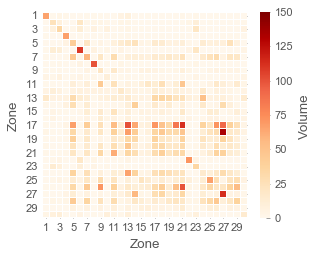

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.style.use('ggplot')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(small_dense_tensor[:, :, 33 + 48], cmap = 'OrRd', vmin = 0, vmax = 150, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0, **axis_font)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0, **axis_font)
ax.set_xlabel("Zone", **axis_font)
ax.set_ylabel("Zone", **axis_font)
ax.axis(**axis_font)
plt.show()
fig.savefig("../images/Ndata_heatmap_actual_values_33.pdf")

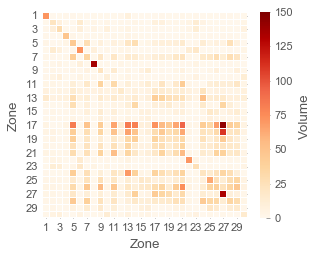

In [71]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(tensor_hat[:, :, 33 + 48], cmap = 'OrRd', vmin = 0, vmax = 150, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_predicted_values_33.pdf")

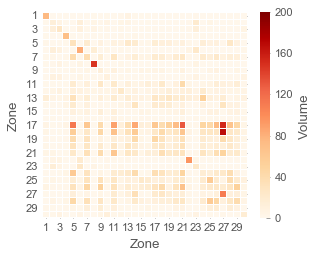

In [72]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(small_dense_tensor[:, :, 32 + 48], cmap = 'OrRd', vmin = 0, vmax = 200, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_actual_values_32.pdf")

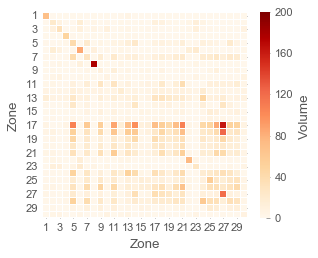

In [73]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(tensor_hat[:, :, 32 + 48], cmap = 'OrRd', vmin = 0, vmax = 200, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_predicted_values_32.pdf")

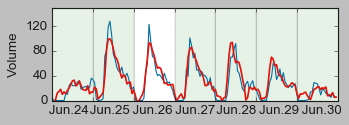

In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[16, 12, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 12, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_time_steps])
ax.set_ylim([0, 150])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
for j in range(7):
    if small_sparse_tensor[16, 12, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 150, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24, 24), ["         Jun.24", "         Jun.25", 
                                        "          Jun.26", "           Jun.27", 
                                       "           Jun.28", "            Jun.29", 
                                       "             Jun.30"])
plt.yticks(np.arange(0, 150, 40), [0, 40, 80, 120], **axis_font)
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_1713.pdf")

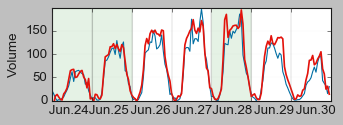

In [75]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.15, 0.20, 0.82, 0.75])
plt.plot(small_dense_tensor[26, 26, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[26, 26, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_time_steps])
ax.set_ylim([0, 200])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
for j in range(7):
    if small_sparse_tensor[26, 26, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 200, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24, 24), ["         Jun.24", "         Jun.25", 
                                        "          Jun.26", "           Jun.27", 
                                       "           Jun.28", "            Jun.29", 
                                       "             Jun.30"])
plt.yticks(np.arange(0, 200, 50), [0, 50, 100, 150, 200], **axis_font)
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_2727.pdf")

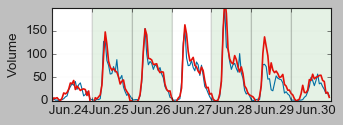

In [76]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.15, 0.20, 0.82, 0.75])
plt.plot(small_dense_tensor[16, 26, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 26, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_time_steps])
ax.set_ylim([0, 200])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
small_sparse_tensor = sparse_tensor[:, :, dense_tensor.shape[2] - pred_time_steps : dense_tensor.shape[2]]
for j in range(7):
    if small_sparse_tensor[16, 26, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 200, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24, 24), ["         Jun.24", "         Jun.25", 
                                        "          Jun.26", "           Jun.27", 
                                       "           Jun.28", "            Jun.29", 
                                       "             Jun.30"])
plt.yticks(np.arange(0, 200, 50), [0, 50, 100, 150, 200], **axis_font)
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_1727.pdf")